# Emotion classification with fine-tuned models

In [6]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

## Load data

In [2]:
df = pd.read_csv('./data/fer2013.csv')

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
NUM_CLASSES = len(CLASS_LABELS)
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

# Transform df column with pixels into a pytorch tensor
pixels = df['pixels']
pixels = pixels.apply(lambda x: x.split(" ")).tolist()
pixels = np.uint8(pixels)
pixels = torch.Tensor(pixels)
pixels = torch.reshape(pixels, (pixels.shape[0], 1, 48, 48))

train_idx = df.index[df['Usage'] == 'Training'].tolist()
val_idx   = df.index[df['Usage'] == 'PublicTest'].tolist()
test_idx  = df.index[df['Usage'] == 'PrivateTest'].tolist()

X_train = pixels[train_idx]
y_train = torch.Tensor(df.iloc[train_idx]['emotion'].tolist())
X_val = pixels[val_idx]
y_val = torch.Tensor(df.iloc[val_idx]['emotion'].tolist())
X_test = pixels[test_idx]
y_test = torch.Tensor(df.iloc[test_idx]['emotion'].tolist())

## Create dataloaders

In [3]:
class EmotionDataset(Dataset):
    '''
    Inputs:
    - images: a [Batch size, Channels, Height, Width] tensor
    - labels: a 1-dimensional tensor corresponding to image labels
    - train: True if you want to apply transformations, False otherwise
    '''
    
    def __init__(self, images, labels, train:bool):
        self.images = images/255
        self.labels = labels
        self.train  = train
        

    def __getitem__(self, index):
        
        # Load the image (as tensor)
        img  = torch.cat((self.images[index], self.images[index], self.images[index]), 0)
        label = self.labels[index]
        
        # Apply transformations
        if self.train == True:
            img = self.transform(img)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        
        return img, label

    
    def __len__(self):
        return len(self.images)
    
    
    def transform(self, img):
      
        # Horizontal flip
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)

        # Add rotations
        if np.random.rand() < 0.3:
            t_rotation = T.RandomRotation(degrees=(-20, 20))
            img = t_rotation(img)

        return img

In [4]:
train_dataset = EmotionDataset(X_train, y_train, train=True)
val_dataset   = EmotionDataset(X_val, y_val, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=256, shuffle=False)

# Define model

In [5]:
from torchvision import models


device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)  
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

C:\Users\javid\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\javid\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [7]:
epochs = 20
history = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        images, labels = batch
        images = images
        predictions = model.forward(images.to(device))
        loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            images, labels = batch
            images = images
            predictions = model.forward(images.to(device))
            loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
            val_losses.append(loss.item())
            accuracy = torch.mean((torch.argmax(predictions, axis=1).cpu() == labels).float()).item()
            val_accuracies.append(accuracy)
    scheduler.step()
    result = {'train_loss': torch.mean(torch.tensor(train_losses)), 'val_loss': torch.mean(torch.tensor(val_losses)), 'val_acc': torch.mean(torch.tensor(val_accuracies))}
    history.append(result)
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))

100%|██████████| 15/15 [00:00<00:00, 53.50it/s]


Epoch [1], train_loss: 1.3786, val_loss: 1.2106, val_acc: 0.5330


100%|██████████| 15/15 [00:00<00:00, 57.28it/s]


Epoch [2], train_loss: 1.1325, val_loss: 1.3225, val_acc: 0.5170


100%|██████████| 15/15 [00:00<00:00, 52.14it/s]


Epoch [3], train_loss: 1.0397, val_loss: 1.1246, val_acc: 0.6002


100%|██████████| 15/15 [00:00<00:00, 58.96it/s]


Epoch [4], train_loss: 0.9750, val_loss: 1.0601, val_acc: 0.6020


100%|██████████| 15/15 [00:00<00:00, 57.64it/s]


Epoch [5], train_loss: 0.9119, val_loss: 1.1973, val_acc: 0.5670


100%|██████████| 15/15 [00:00<00:00, 47.41it/s]


Epoch [6], train_loss: 0.8631, val_loss: 1.1507, val_acc: 0.5796


100%|██████████| 15/15 [00:00<00:00, 57.88it/s]


Epoch [7], train_loss: 0.8034, val_loss: 1.0773, val_acc: 0.6226


100%|██████████| 15/15 [00:00<00:00, 57.13it/s]


Epoch [8], train_loss: 0.7525, val_loss: 1.1162, val_acc: 0.5985


100%|██████████| 15/15 [00:00<00:00, 58.70it/s]


Epoch [9], train_loss: 0.6969, val_loss: 1.0887, val_acc: 0.6189


100%|██████████| 15/15 [00:00<00:00, 57.59it/s]


Epoch [10], train_loss: 0.6377, val_loss: 1.1389, val_acc: 0.6210


100%|██████████| 15/15 [00:00<00:00, 58.61it/s]


Epoch [11], train_loss: 0.5941, val_loss: 1.1639, val_acc: 0.6239


100%|██████████| 15/15 [00:00<00:00, 58.94it/s]


Epoch [12], train_loss: 0.5439, val_loss: 1.1785, val_acc: 0.6408


100%|██████████| 15/15 [00:00<00:00, 58.48it/s]


Epoch [13], train_loss: 0.5091, val_loss: 1.1856, val_acc: 0.6395


100%|██████████| 15/15 [00:00<00:00, 58.22it/s]


Epoch [14], train_loss: 0.4603, val_loss: 1.1898, val_acc: 0.6379


100%|██████████| 15/15 [00:00<00:00, 58.70it/s]


Epoch [15], train_loss: 0.4166, val_loss: 1.3594, val_acc: 0.6074


100%|██████████| 15/15 [00:00<00:00, 57.85it/s]


Epoch [16], train_loss: 0.3936, val_loss: 1.2993, val_acc: 0.6343


100%|██████████| 15/15 [00:00<00:00, 58.03it/s]


Epoch [17], train_loss: 0.3500, val_loss: 1.3930, val_acc: 0.6314


100%|██████████| 15/15 [00:00<00:00, 58.73it/s]


Epoch [18], train_loss: 0.3244, val_loss: 1.4589, val_acc: 0.6170


100%|██████████| 15/15 [00:00<00:00, 58.23it/s]


Epoch [19], train_loss: 0.3048, val_loss: 1.5237, val_acc: 0.6233


100%|██████████| 15/15 [00:00<00:00, 58.84it/s]

Epoch [20], train_loss: 0.2813, val_loss: 1.6477, val_acc: 0.6290


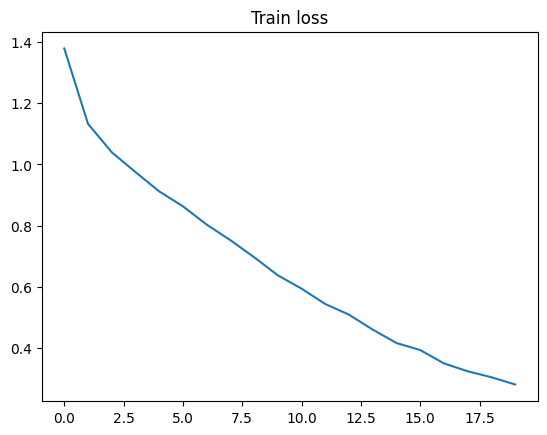

In [8]:
plt.plot([i['train_loss'].item() for i in history])
plt.title("Train loss")
plt.show()

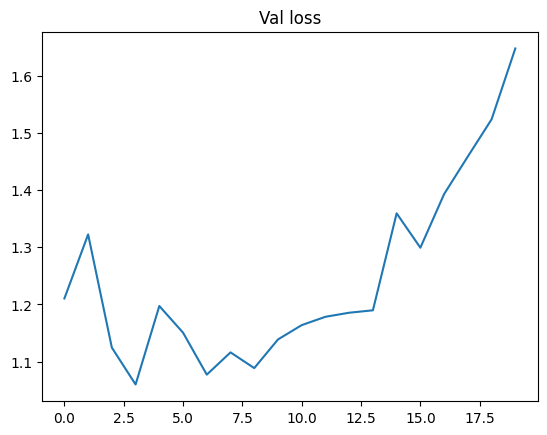

In [9]:
plt.plot([i['val_loss'].item() for i in history])
plt.title("Val loss")
plt.show()

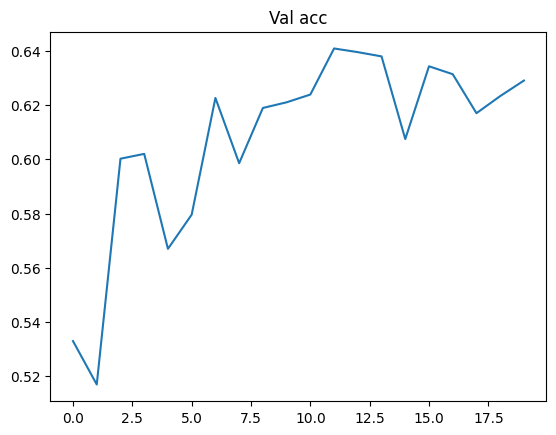

In [10]:
plt.plot([i['val_acc'].item() for i in history])
plt.title("Val acc")
plt.show()